In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
from utils.montecarlo import *
from mcmc.algorithms.metropolis_hastings import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

## Overview

This notebook builds the core foundations of Markov Chain Monte Carlo (MCMC) diagnostics
using the simplest meaningful setting: a two–dimensional Gaussian target distribution.
The aim is not to demonstrate advanced samplers, but to understand **how to judge whether an
MCMC algorithm is actually working**.  
The diagnostics introduced here will be reused throughout all later notebooks.

---

### Why a 2D Gaussian?

A bivariate Gaussian is the ideal sandbox for learning MCMC behaviour:

- Its mean, covariance, and contours are known exactly.
- It exhibits correlation and anisotropy without pathological geometry.
- Trace plots, autocorrelations, mixing, and ESS are easy to visualize.
- Any mixing failure comes from the **algorithm**, not the target.

Our target is

$$
X \sim \mathcal{N}(\mu, \Sigma),
$$

with

$$
\mu = \begin{bmatrix} 1 \\ 2 \end{bmatrix},
\qquad
\Sigma =
\begin{bmatrix}
1 & 0.5 \\
0.5 & 1
\end{bmatrix}.
$$

The correlation ensures that proposal tuning and chain efficiency truly matter.

---

### Why Start With Metropolis–Hastings?

Although modern samplers exist (AM, DR, DRAM, HMC, NUTS), nearly all diagnostics rely on the same principles:

- how fast the chain forgets its start point,
- how correlated successive samples are,
- how efficiently the chain explores the target.

Metropolis–Hastings exposes these behaviours with minimal machinery, making it the ideal
“laboratory’’ for learning:

- acceptance rate behaviour,
- mixing and trace diagnostics,
- autocorrelation structure,
- integrated autocorrelation time (IAT),
- effective sample size (ESS).

Once mastered here, these ideas transfer directly to all advanced MCMC methods.

---

### What This Notebook Covers

This notebook develops the essential diagnostic toolkit:

- Laplace approximation for principled initialization,
- Burn-in and transient removal,
- Visual mixing diagnostics,
- Autocorrelation function (ACF),
- Integrated autocorrelation time (IAT),
- Effective sample size (ESS).

All examples use the same 2D Gaussian target so behaviour is easy to interpret.

---

### What Later Notebooks Will Reuse

Subsequent notebooks will apply these diagnostics—without re-deriving them—to:

- Adaptive Metropolis (AM),
- Delayed Rejection (DR),
- Delayed Rejection Adaptive Metropolis (DRAM),

and to more challenging targets such as banana distributions, Gaussian mixtures, and
heavy-tailed densities.

We will compare acceptance rates, mixing, ACF decay, IAT, and ESS to evaluate algorithmic
performance.

This notebook forms the **diagnostic foundation** for the entire MCMC series.


## Target Disribution : 2D Gaussian Distribution

In [4]:
target_mean = np.array([1,2])
target_cov = build_2D_covariance_matrix(1,1,0.5)

target_pdf_2DGaussian = lambda x: multivariate_normal_pdf_eval(x.reshape(1,-1), mean=target_mean, cov=target_cov)
target_logpdf_2DGaussian = lambda x: multivariate_normal_logpdf_eval(x.reshape(1,-1), mean=target_mean, cov=target_cov)

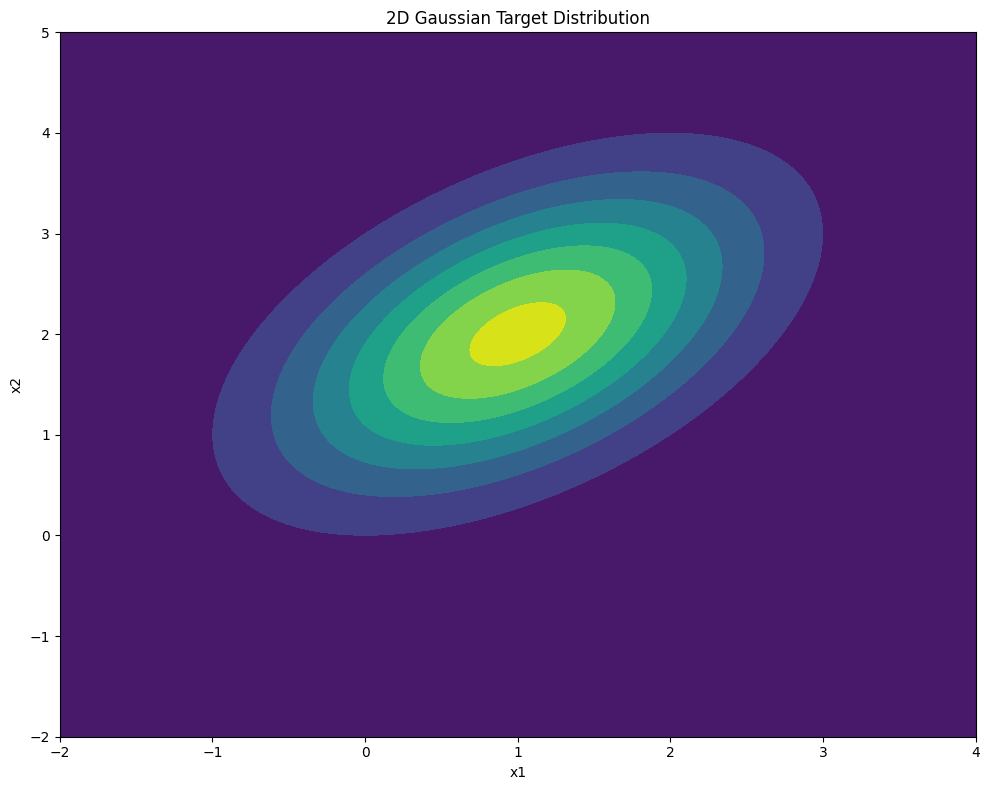

In [15]:
plt.figure(1, figsize=(10,8))

xgrid = np.linspace(-2,4,400)
ygrid = np.linspace(-2,5,400)

XX, YY, logpdf_evals = eval_on_2D_grid(xgrid, ygrid, target_pdf_2DGaussian)

plt.contourf(XX, YY, logpdf_evals)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("2D Gaussian Target Distribution")
save_path_1 = os.path.join(ROOT, "images/mcmc/2D_Gaussian_target_distribution.png")
plt.tight_layout()
plt.savefig(save_path_1)
plt.show()

## Target Distribution and Laplace Approximation

In this section we derive a Laplace approximation for our two-dimensional Gaussian target
distribution. Although the approximation is exact for a Gaussian, we include this section
because the same workflow applies to non-Gaussian targets (e.g., banana distribution).

---

### Target Distribution and Log-Density

Our target distribution is

$$
X = (x_1,x_2)^\top \sim \mathcal{N}(\mu,\Sigma)
$$

with

$$
\mu =
\begin{bmatrix}
1 \\ 2
\end{bmatrix},
\qquad
\Sigma =
\begin{bmatrix}
1 & 0.5 \\
0.5 & 1
\end{bmatrix}.
$$

The unnormalized log-density is

$$
\log \pi(\theta)
=
-\tfrac12 (\theta - \mu)^\top \Sigma^{-1} (\theta - \mu)
+ \text{constant},
\qquad
\theta =
\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}.
$$

From Gaussian identities:

$$
\nabla \log \pi(\theta) = -\Sigma^{-1}(\theta - \mu)
$$

$$
\nabla^2 \log \pi(\theta) = -\Sigma^{-1}
$$

---

### MAP Estimate

The MAP point satisfies

$$
\nabla \log \pi(\theta^{MAP}) = 0
\quad\Longleftrightarrow\quad
\Sigma^{-1}(\theta^{MAP} - \mu) = 0.
$$

Thus,

$$
\theta^{MAP} =
\begin{bmatrix}
1 \\ 2
\end{bmatrix}
$$

---

### Laplace Covariance Estimate

The Laplace approximation fits a Gaussian

$$
\mathcal{N}(m, C)
$$

with

$$
m = \theta^{MAP},
\qquad
C = \left[-\nabla^2 \log \pi(\theta^{MAP})\right]^{-1}.
$$

For this Gaussian target:

$$
\nabla^2 \log \pi(\theta^{MAP}) = -\Sigma^{-1}
$$

$$
C = (\Sigma^{-1})^{-1} = \Sigma.
$$

So the Laplace covariance exactly matches the true covariance.

---

### Laplace-Based Initialization for MCMC

Laplace approximation provides:

- **Initialization**
  
  $$
  \theta_0 = \theta^{MAP}
  $$

- **Curvature (proposal scale)**

  $$
  C = \left[-\nabla^2 \log \pi(\theta^{MAP})\right]^{-1}
  $$

- **Proposal covariance (scaled)**

  $$
  \Sigma_{\text{prop}} = \kappa\, C
  $$

This typically yields:

- shorter burn-in  
- better early acceptance  
- improved scaling in stiff directions  

Even though this example is Gaussian (Laplace is exact), this lays the foundation for using
Laplace initialization on complex distributions later.

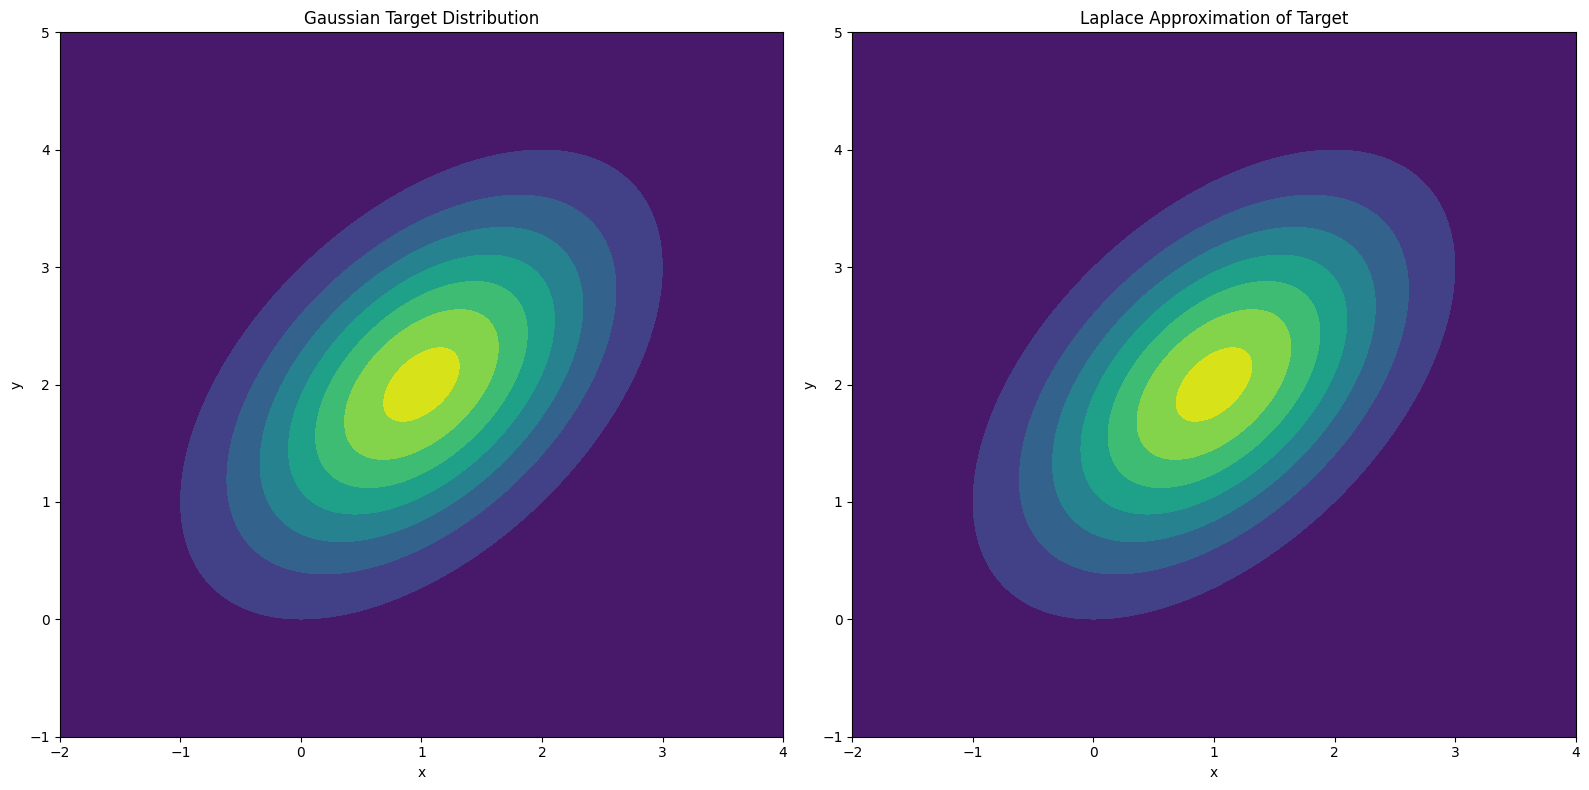

In [16]:
# -------------------------------------------------------
# 1. Define the grid
# -------------------------------------------------------
xgrid = np.linspace(-2, 4, 300)
ygrid = np.linspace(-1, 5, 300)

# -------------------------------------------------------
# 2. Evaluate Target distribution
# -------------------------------------------------------
XX, YY, target_vals = eval_on_2D_grid(
    xgrid,
    ygrid,
    target_pdf_2DGaussian)

# -------------------------------------------------------
# 3. Evaluate Laplace Approximation (Gaussian)
# -------------------------------------------------------
gauss_mean = np.array([1, 2])
gauss_cov = build_2D_covariance_matrix(1.0, 1.0, 0.5)

# Use scipy Gaussian evaluator on grid
XX, YY, laplace_target_vals = eval_on_2D_grid(
    xgrid,
    ygrid,
    target_pdf_2DGaussian)

# -------------------------------------------------------
# 4. Plot both distributions
# -------------------------------------------------------
plt.figure(figsize=(16, 8))

# Left subplot: Target Distribution
ax1 = plt.subplot(1, 2, 1)
ax1.contourf(XX, YY, target_vals)
ax1.set_title("Gaussian Target Distribution")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xlim(-2, 4)
ax1.set_ylim(-1, 5)

# Right subplot: Laplace approximation
ax2 = plt.subplot(1, 2, 2)
ax2.contourf(XX, YY, laplace_target_vals)
ax2.set_title("Laplace Approximation of Target")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_xlim(-2, 4)
ax2.set_ylim(-1, 5)

save_path_2 = os.path.join(ROOT, "images/mcmc/2D_Gaussian_laplace_approx.png")
plt.tight_layout()
plt.savefig(save_path_2)
plt.show()


# Metropolis-Hastings for 2D Gaussian Distribution

In [7]:
# Target Distribution 
target_mean = np.array([1,2])
target_cov = build_2D_covariance_matrix(1,1,0.5)
target_logpdf = lambda x: multivariate_normal_logpdf_eval(x.reshape(1,-1), mean=target_mean, cov=target_cov)[0]

# initial conditions
initial_sample = np.array([10,10])
initial_cov = build_2D_covariance_matrix(1,1,0.5) # from Laplace Approximation
num_samples = 50000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler


## Metropolis-Hastings 
mh_samples = mh_mcmc(initial_sample, initial_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, verbose=True)

samples = mh_samples.samples
print("Accepted Samples Ratio:", mh_samples.accept_rate)

Finished sample 1000, acceptance ratio = 0.358
Finished sample 2000, acceptance ratio = 0.344
Finished sample 3000, acceptance ratio = 0.340
Finished sample 4000, acceptance ratio = 0.337
Finished sample 5000, acceptance ratio = 0.336
Finished sample 6000, acceptance ratio = 0.333
Finished sample 7000, acceptance ratio = 0.337
Finished sample 8000, acceptance ratio = 0.337
Finished sample 9000, acceptance ratio = 0.340
Finished sample 10000, acceptance ratio = 0.342
Finished sample 11000, acceptance ratio = 0.343
Finished sample 12000, acceptance ratio = 0.344
Finished sample 13000, acceptance ratio = 0.345
Finished sample 14000, acceptance ratio = 0.344
Finished sample 15000, acceptance ratio = 0.345
Finished sample 16000, acceptance ratio = 0.345
Finished sample 17000, acceptance ratio = 0.346
Finished sample 18000, acceptance ratio = 0.348
Finished sample 19000, acceptance ratio = 0.349
Finished sample 20000, acceptance ratio = 0.349
Finished sample 21000, acceptance ratio = 0.349
F

## Burn-in

In [8]:
new_mh_result= mcmc_burnin_and_thin(mh_samples, burnin_frac=0.5, thin_frac=1)
samples = new_mh_result.samples
print("Accepted Samples Ratio:", new_mh_result.accept_rate)

Accepted Samples Ratio: 0.35016


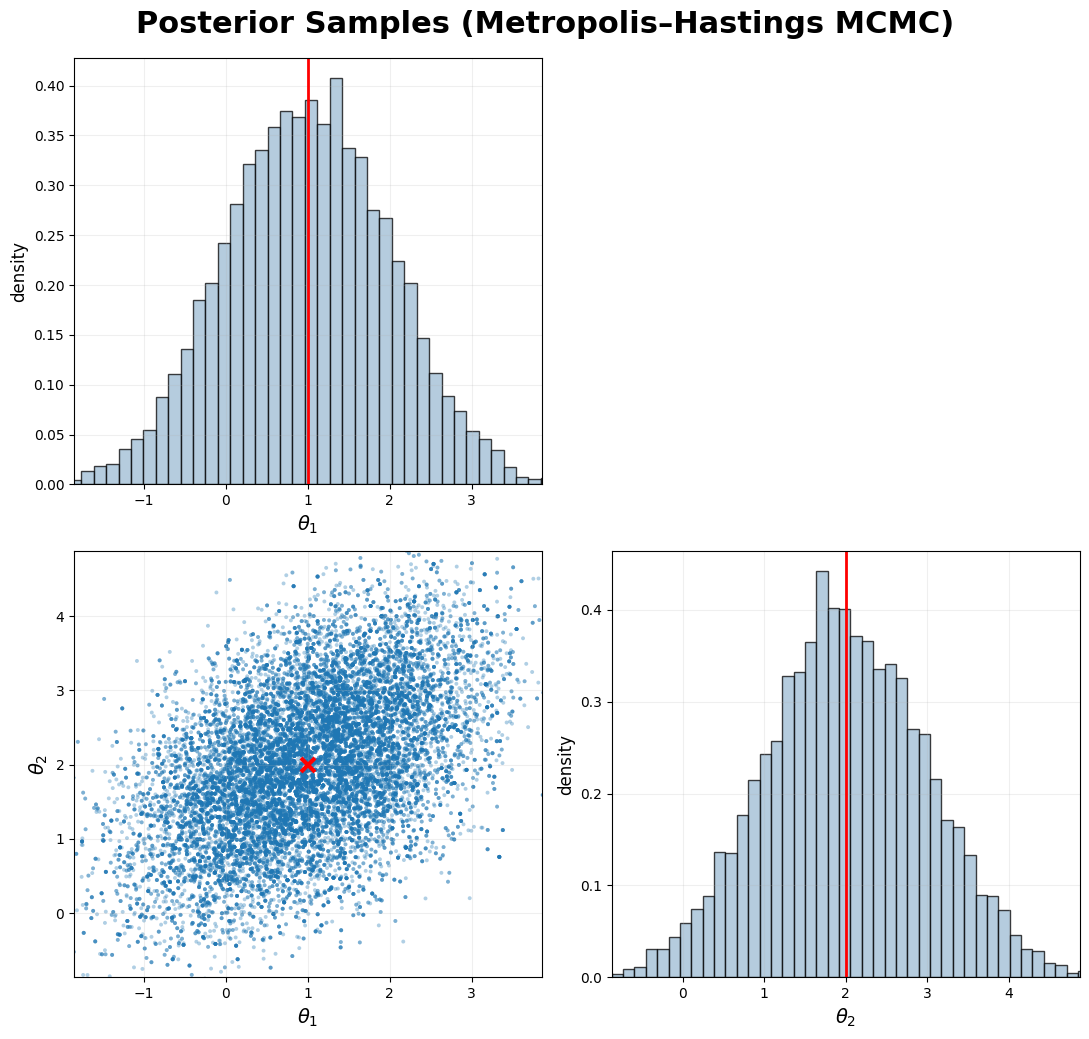

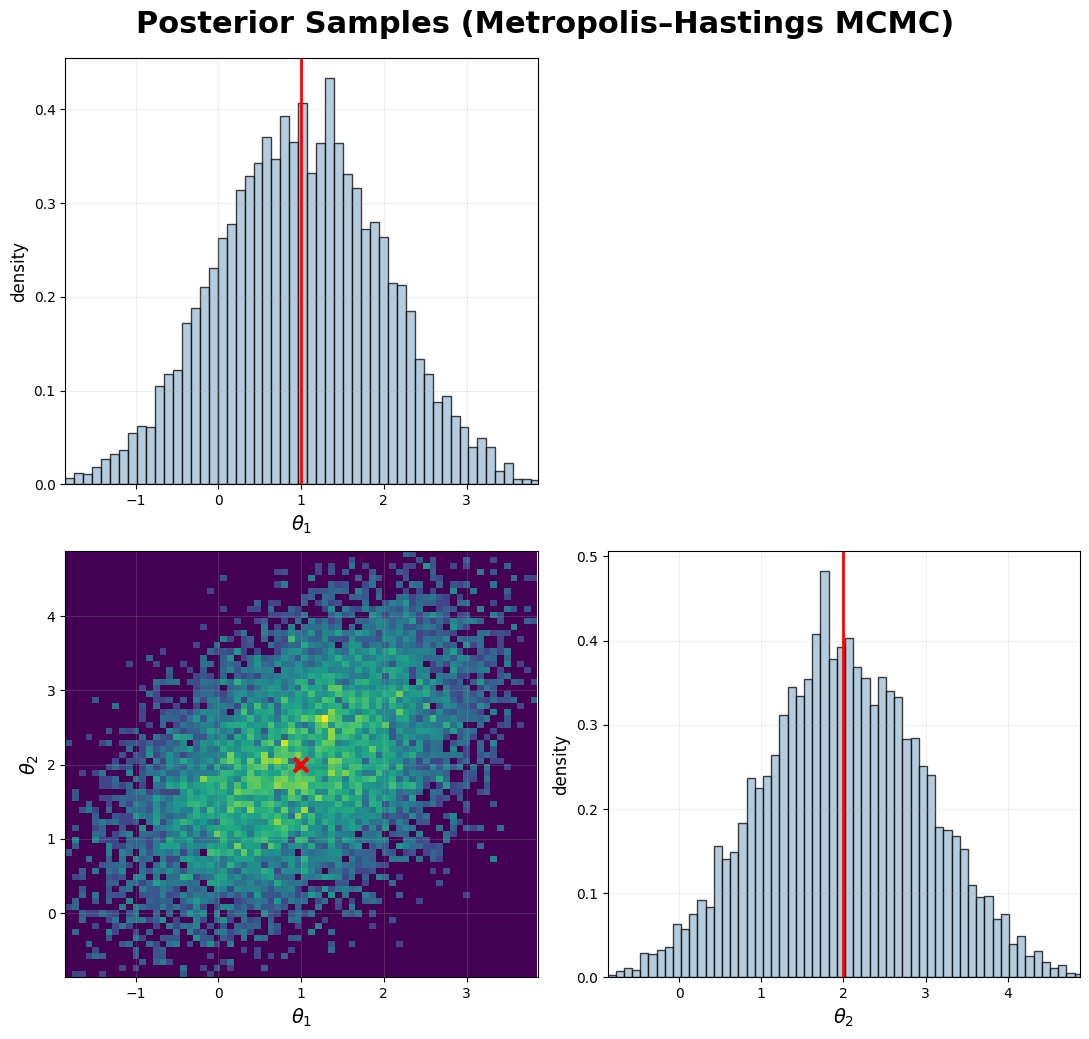

In [9]:
plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=gauss_mean,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$"],
    hist_plot=False,
)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=gauss_mean,
    labels=[r"$\theta_1$", r"$\theta_2$"],
    hist_plot=True,
    nbins=70
)
plt.show()

## Estimation of Mean

In [10]:
print("True Mean        = ", target_mean)
print("Estimated Mean   = ", np.mean(samples, axis=0))

True Mean        =  [1 2]
Estimated Mean   =  [0.99809535 2.00425018]


## Mixing

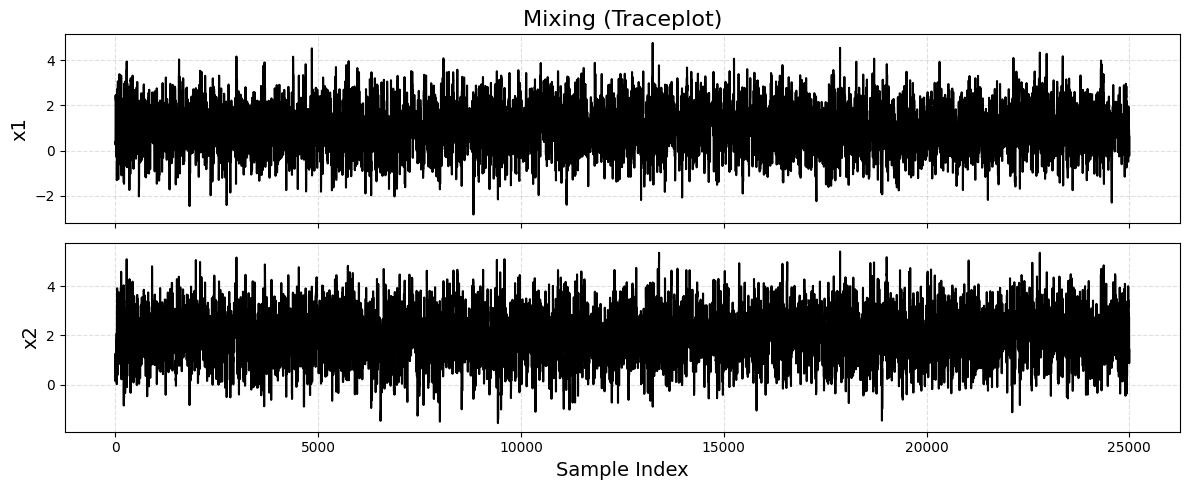

In [11]:
plot_mixing_2d(samples, dim_names=("x1", "x2"))

## Autocorrelation

In MCMC, samples are not independent—each value comes from the previous one:
$$
\theta_{t+1} \sim K(\theta_{t+1} \mid \theta_t).
$$

Because of this dependence, the chain moves locally and each new sample contains only
partial new information.

The autocorrelation at lag $\tau$ is
$$
\rho(\tau)
=
\frac{\operatorname{Cov}(\theta_t,\,\theta_{t+\tau})}
     {\operatorname{Var}(\theta_t)}.
$$

Interpretation:

- $\rho(\tau)=0$ → independent samples  
- $\rho(\tau)>0$ → correlated or “sticky” chain  
- slower decay of $\rho(\tau)$ → slower mixing and lower efficiency  

Autocorrelation reveals the **information loss** caused by dependence in MCMC samples.
A highly correlated chain explores the target slowly and produces fewer effective samples.


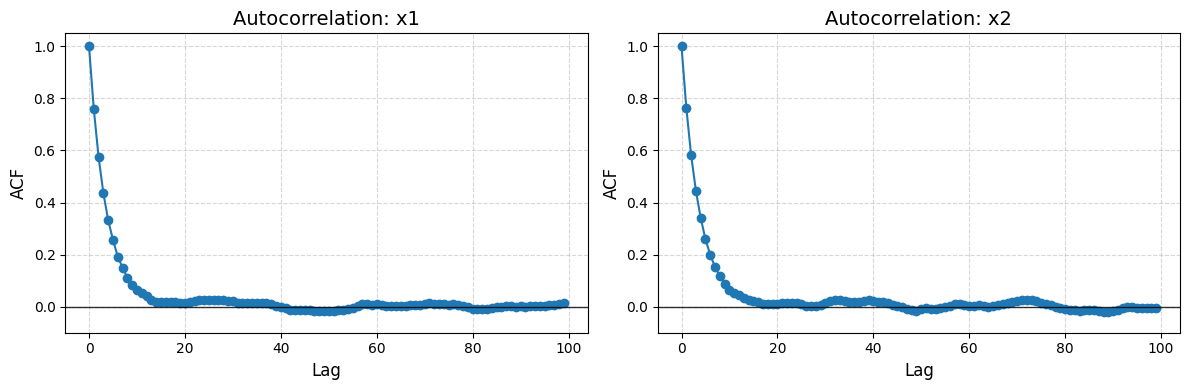

In [12]:
lags, acf = autocorrelation_vectorized(samples, max_lag=100)
plot_autocorrelation_2d(lags, acf, dim_names=("x1", "x2"))

## Integrated Autocorrelation (IAC)

Autocorrelation at a single lag does not measure sampler efficiency.  
What matters is the **total correlation** accumulated across all lags.

The **integrated autocorrelation (IAC)** is defined as
$$
\tau_{\text{int}}
=
1 + 2 \sum_{\tau=1}^{\infty} \rho(\tau).
$$

IAC quantifies how many correlated MCMC samples contain the same information  
as a single independent draw.

Interpretation:

- $\tau_{\text{int}} = 1$ → chain behaves like independent sampling  
- $\tau_{\text{int}} = 5$ → five MCMC samples provide the information of one independent sample  
- larger $\tau_{\text{int}}$ → stronger correlation → lower efficiency  

IAC connects the **autocorrelation structure** of the chain to its **statistical efficiency**.


## Effective Sample Size (ESS)

The Effective Sample Size measures the **true information content** of an MCMC chain.  
Given \(N\) correlated samples, ESS answers:

**How many independent samples would carry the same information?**

ESS is defined using the integrated autocorrelation (IAC):
$$
\text{ESS}
=
\frac{N}{\tau_{\text{int}}}
=
\frac{N}{
1 + 2\sum_{\tau=1}^{\infty}\rho(\tau)
}.
$$

Interpretation:

- independent chain → $\rho(\tau)=0$ → ESS = \(N\)  
- highly autocorrelated chain → ESS \(\ll N\)  
- ESS reflects **usable**, not raw, sample count

A sampler that produces many correlated draws per second is worse than one producing fewer but more independent draws.  
The correct comparison metric is:
$$
\text{Effective Samples per Second}.
$$

ESS is the gold standard for evaluating MCMC efficiency.


## Integrated Auto-Correlation & Effective Sample Size

In [13]:
iac, acf, lags = integrated_autocorrelation(samples, max_lag=300)
ess = effective_sample_size(samples, iac)

N = samples.shape[0]
efficiency = ess / N * 100  # percentage

print(f"Total samples: {N}\n")

for k in range(len(iac)):
    print(f"Dimension {k}:")
    print(f"  IAC:          {iac[k]:.4f}")
    print(f"  ESS:          {ess[k]:.2f}")
    print(f"  Efficiency:   {efficiency[k]:.1f}%   "
          f"({efficiency[k]:.1f}% as effective as independent samples)")
    print()


Total samples: 25000

Dimension 0:
  IAC:          8.0779
  ESS:          3094.85
  Efficiency:   12.4%   (12.4% as effective as independent samples)

Dimension 1:
  IAC:          8.2324
  ESS:          3036.77
  Efficiency:   12.1%   (12.1% as effective as independent samples)

